<a href="https://colab.research.google.com/github/SaraElwatany/Implementation-Of-SOM-Maps-from-Scratch/blob/main/Assignment3_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports**

## **Note:** An Upload Button would Ask you to upload the CSV File from your Local Computer

In [ ]:
import math

import numpy as np
import pandas as pd

from google.colab import files

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib import animation, colors
from matplotlib import patches as patches
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## **Helper Functions**

In [ ]:
# A Function to decay the learning rate
def learning_rate_decay(grid_size, maxiter, lr, iter):
  exponent = -1 * iter * (math.log(grid_size)/maxiter)
  return (lr * math.exp(exponent))

In [ ]:
# A Function to decay the radius of the window
def neighborhood_radius_diminsh(grid_size, maxiter, r, iter):
  exponent = -1 * iter * (math.log(grid_size)/maxiter)
  return (r * math.exp(exponent))

In [ ]:
# A Function to update the weights of the SOM
def update_weight(old_n, bmu_n, x_sample, lr, r):
  d = np.linalg.norm(old_n - bmu_n)
  w_j = np.exp( - (d**2) / (2*(r**2)))
  new_n = old_n + (lr * w_j * (x_sample - old_n))
  return new_n  # Return the new weights

In [ ]:
# A Function to get the Euclidean Distance Between 2 vectors/Matrices
def get_euc_dist(mat1, mat2, axis):
  return np.linalg.norm((mat1 - mat2), axis=axis)

In [ ]:
# A Function to get the winner neuron (BMU) from the SOM
def get_winner(x_sample, som_map):
  # Initialize an empty matrix to store the euclidean distance from each neuron for a given data point/sample
  euc_dist = 0
  smallest_dist = np.sqrt(som_map.shape[2]) # initialise with max distance
  # Interate through each neuron in the GRID/SOM
  for row in range(0, som_map.shape[0]):
    for col in range(0, som_map.shape[1]):
      # Get the euclidean distance between the data point & the neuron
      euc_dist = get_euc_dist(som_map[row][col], x_sample, axis=0)
      if euc_dist <= smallest_dist:
        smallest_dist = euc_dist
        # Get the location corresponding to minimum euclidean distance (BMU)
        bmu_row_loc, bmu_col_loc = row , col
  return bmu_row_loc, bmu_col_loc   # Return the row & column indicies respectively for the BMU

In [ ]:
# A Function to compute the SOM Weights
def get_som(x, n_rows, n_columns, iterations, lr, r):

  # Get the number of features/variables
  n_features = x.shape[1]
  print('Available Number of Features: ' , n_features)
  # Get the number of samples
  n_samples = x.shape[0]
  print('Available training examples: ' , n_samples)

  # Initialize a SOM Map with random weights
  som_map = np.random.rand(n_rows, n_columns, n_features)
  print('SOM Map Shape: ' , som_map.shape)
  #print('SOM Map: \n' , som_map)

  # Get the initial values for the radius & the learning rate
  new_r = r
  new_lr = lr

  # Initialize an empty matrix that holds the norms from each neuron in the grid
  euc_mat = np.zeros(shape=(n_rows, n_columns), dtype=float)

  # For each iteration pick a random sample from the dataset and update the winner neuron and its neighbors
  for iteration in range(0, iterations):

    # Select a training example at random
    random_no = np.random.randint(0, n_samples)
    x_sample = x[random_no, :].reshape(n_features)
    #print('X sample shape: ' , x_sample.shape)


    # Get the Location Corresponding to Minimum Euclidean Distance (BMU)
    bmu_row_loc, bmu_col_loc = get_winner(x_sample, som_map)
    #print(f'Sample: {random_no}', f'Corresponding Row Location in Grid: {bmu_row_loc}', f'Corresponding Column Location in Grid: {bmu_col_loc}')

    # Update the weights within the window
    for row in range(max(0, bmu_row_loc - r), min(n_rows, bmu_row_loc + r + 1)):
        for col in range(max(0, bmu_col_loc - r), min(n_columns, bmu_col_loc + r + 1)):
            #print('Success In Updating Weights in => ', f'Row: {row}', f'Column: {col}')
            som_map[row, col, :] = update_weight(som_map[row, col, :], som_map[bmu_row_loc, bmu_col_loc, :], x_sample, new_lr, new_r)

    # Update the Radius
    new_r = math.ceil(neighborhood_radius_diminsh(grid_size, iterations, r, iteration))
    #print(f'New Radius: {new_r}')

    # Update the Learning Rate
    new_lr = learning_rate_decay(grid_size, iterations, lr, iteration)
    #print(f'New learning rate: {new_lr}')

  return som_map    # Return the SOM Weights

In [ ]:
# A Function to compute the distance map manually (the distance between each neuron in the map & each other neuron)
def distance_map(som_map):

    # Get the number of rows & the number of columns of the GRID/SOM
    n_rows, n_cols, n_features = som_map.shape
    flatten_som_map = som_map.reshape((n_rows * n_columns, n_features))

    # Calculate pairwise distances between neurons
    distances = cdist(flatten_som_map, flatten_som_map, 'euclidean')

    # Reshape the Distances 1D array into a Square Matrix
    distances_square = distances.reshape((n_rows, n_cols, n_rows, n_cols))

    # Calculate the minimum distance for each neuron
    min_distances = np.min(np.min(distances_square, axis=2), axis=0)

    return min_distances  # Return the distance map

In [ ]:
# A Function that plots the data points on the SOM (to visualize the clusters)
def plot_clusters(x, y, som_map):

  # Get the number of features
  n_features = x.shape[1]

  # 2 different markers with 2 different colors for the 2 classes
  class_markers = ['o', 's']
  class_colors = ['b', 'c']

  # Iterate through each data point & find the closest neuron weights to it (winner neuron / BMU)
  for sample in range(0, x.shape[0]):
      x_sample = x[sample, :].reshape(n_features)
      w_row, w_col = get_winner(x_sample, som_map)    # Get the winner neuron's coordinates (row & column)
      plt.plot(w_row+0.05, w_col+0.05, class_markers[y[sample]], markeredgecolor=class_colors[y[sample]], markerfacecolor = 'None', markersize=10, markeredgewidth=2) # Plot the data point

## **Data Reading**

In [ ]:
uploaded = files.upload()

Saving breast-cancer - breast-cancer.csv to breast-cancer - breast-cancer (1).csv


In [ ]:
# Set the path to the csv file & read it using pandas
data_path = "/content/breast-cancer - breast-cancer.csv"
cancer_data = pd.read_csv(data_path)

In [ ]:
# Visualize the csv file
cancer_data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
# Map the labels of the classes from strings to integers (Encoding Labels), where Malignant => represented by 1 , Begnin => represented by 0
cleanup_nums = {"diagnosis": {"M": 1, "B": 0}}
cancer_data = cancer_data.replace(cleanup_nums)

In [ ]:
# Visualize the csv file after modification
cancer_data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
# Dicover the keys in the Dataframe (csv file)
cancer_data.keys()

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
# Get the Features & the targets from the Dataframe
x = cancer_data.drop(['id', 'diagnosis'], axis=1)
y = cancer_data['diagnosis']

In [ ]:
# Visualize the Features/Variables
x

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
# Visualize the Targets
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [ ]:
# Get the number of Non Null target records
y.count()

569

In [ ]:
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [ ]:
# Get the Distribution of the Dataset
print(f'Number of Begnin Samples: {y.value_counts()[0]}')
print(f'Number of Malignant Samples: {y.value_counts()[1]}')

Number of Begnin Samples: 357
Number of Malignant Samples: 212


In [ ]:
# Scale the data between 0 and 1
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

print("Min Value: ", x.min())
print("Max Value: ", x.max())

Min Value:  0.0
Max Value:  1.0000000000000002


In [ ]:
# Cast the Features & Targets to numpy arrays
x = np.array(x)
y = np.array(y)

## **Begin Training (Get the SOM)**

In [ ]:
# Initialize number of iterations
n = 4500
# Initialize the initial neighborhood radius of the BMU (radius of the window)
r = 10
# Initialize the initial learning rate
lr = 0.01
# Initialize the grid size (grid_size = n_rows*n_columns)
n_rows = 15 #20
n_columns = 15 #20
grid_size = n_rows*n_columns

## **Comments**

- The Choice of the Grid Size would typically depend on your data, how it is distributed, the features used and other.

- This means that you will have to actually try different values & observe how these values will reflect on your Clustering of Data.

- Typically, you wouldn't want to have a very large Grid Size cause that would lead to a lot of noise, the reason this happens is basically the larger the amount of neurons, the more the options (neurons/weights) the data points would have to choose from, thus each data point may end in a seperate neuron, increasing the noise.

- The Grid Size also shouldn't be very small with respect to our data's distribution cause that could also lead to alot of noise and overlapping between our data points in the SOM Grid.

- In our Case, alot of sizes where chosen, and using the trial & error a Grid Size of 15 did a pretty good job in our clustering along with the other hyperparameters' value of choice.

In [ ]:
# Get the SOM
som_map = get_som(x, n_rows, n_columns, n, lr, r)

Available Number of Features:  30
Available training examples:  569
SOM Map Shape:  (15, 15, 30)


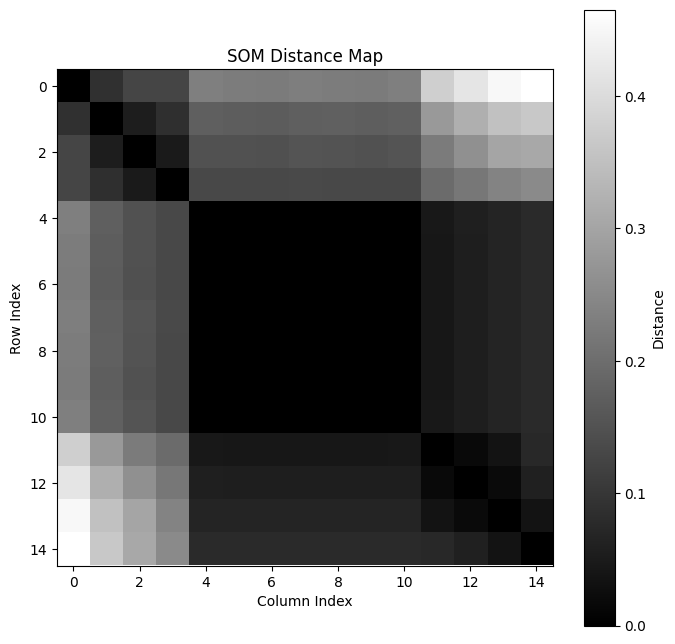

In [ ]:
# Get the Distance Map
dist_map = distance_map(som_map)

# Plot the distance map as a heatmap
plt.figure(figsize=(8, 8))
plt.imshow(dist_map, cmap='gray', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('SOM Distance Map')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

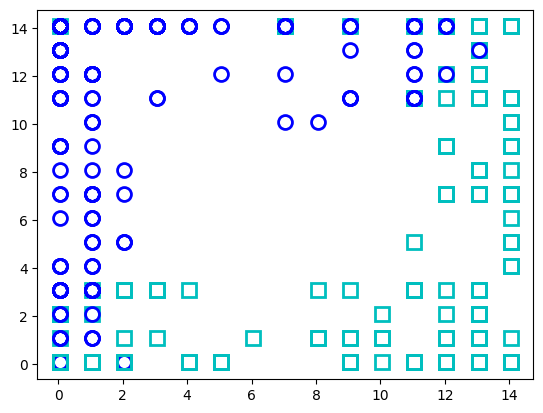

In [ ]:
# Visualize the clusters
plot_clusters(x, y, som_map)

## **Comments**

- Observing the Data distribution (clustering) plot you can see that the SOM did its job, where very limited data points where misclassified compared to the other correctly classified samples.

- Observing the Distance Map plot you can see that there is clearly one cluster/class that dominates the right hand side of the SOM (weights are close to each other) that has the color dark grey, while the left hand side of the SOM the color shifts from dark grey to light grey indicating the presence of another cluster, also the middle part of the Distance Map has black color which matches the absence of data points (could be a seperator) with our cluster visualization plot.